In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.nn import SmoothL1Loss
from torch.nn import L1Loss
from torch.nn import LayerNorm
import math

In [2]:
numInputs = 21
numOutputs = 7
numEpochs = 150
batch_size = 128
all_features = 'No'
data_splitting = 'Yes'

In [3]:
class Model(nn.Module):
    def __init__(self, in_features=numInputs, h1=batch_size, h2=96, h3=50, h4=30, h5=25, h6=18, h7=15,
                 h8=96, h9=50, h10=30, h11=25, h12=18, h13=15, out_features=numOutputs):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.batchLayer = nn.BatchNorm1d(h1)
        self.layerNorm = LayerNorm(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.dropout1 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.dropout2 = nn.Dropout(0.2)
        self.fc6 = nn.Linear(h5, h6)
        self.fc7 = nn.Linear(h6, h7)
        self.dropout3 = nn.Dropout(0.2)
        self.fc8 = nn.Linear(h7, h8)
        self.fc9 = nn.Linear(h8, h9)
        self.dropout4 = nn.Dropout(0.2)
        self.fc10 = nn.Linear(h9, h10)
        self.fc11 = nn.Linear(h10, h11)
        self.dropout5 = nn.Dropout(0.2)
        self.fc12 = nn.Linear(h11, h12)
        self.fc13 = nn.Linear(h12, h13)
        self.out = nn.Linear(h13, out_features)

        # Apply He Initialization to the linear layers
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu', a=0.2)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.PReLU):
                # Initialize PReLU parameters
                init.constant_(m.weight, 0.25)  # Set the negative slope to 0.25

    def forward(self, x):
        x=self.fc1(x)
        x = self.batchLayer(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))  
        x = self.layerNorm(x)
        x=self.fc2(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))  
        x=self.fc3(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))  
        x = self.dropout1(x)
        x=self.fc4(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device)) 
        x=self.fc5(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device)) 
        x = self.dropout2(x)
        x=self.fc6(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))  
        x=self.fc7(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x = self.dropout3(x)
        x=self.fc8(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x=self.fc9(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x = self.dropout4(x)
        x=self.fc10(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x=self.fc11(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x = self.dropout5(x)
        x=self.fc12(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x=self.fc13(x)
        x = F.prelu(x, weight=torch.Tensor([0.25]).to(x.device))
        x = self.out(x)
        
        return x

In [4]:
torch.manual_seed(23)
model = Model()
model.init_weights()
model

Model(
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (batchLayer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layerNorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=128, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=50, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=50, out_features=30, bias=True)
  (fc5): Linear(in_features=30, out_features=25, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc6): Linear(in_features=25, out_features=18, bias=True)
  (fc7): Linear(in_features=18, out_features=15, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc8): Linear(in_features=15, out_features=96, bias=True)
  (fc9): Linear(in_features=96, out_features=50, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc10): Linear(in_features=50, out_features=30, bias=True)
  (fc11): Linear(in_features=30, out_features=25

In [5]:
robot_df = pd.read_csv('./data/CRL-Dataset-CTCR-Pose.csv')
robot_df

,a1,beta1,a2,beta2,a3,beta3,delta_a1,delta_b1,delta_a2,delta_b2,...,sigma_21,sigma_22,sigma_23,x3,y3,z3,n3,sigma_31,sigma_32,sigma_33
0,-1.038446,-8.648766,-0.934423,-4.659318,-0.518523,-3.419294,-1.038446,-8.648766,-0.934423,-4.659318,...,0.086870,-0.409851,0.548841,-51.311665,-52.394960,-196.172089,0.651852,0.402930,-0.085287,0.636759
1,-0.849078,-12.935190,-0.948167,-4.141172,-0.835220,-1.755485,0.189368,-4.286425,-0.013744,0.518146,...,0.122501,-0.453856,0.544632,-50.692317,-60.809199,-208.382272,0.598864,0.371977,-0.123544,0.698378
2,-1.017749,-12.567895,-0.812003,-12.013610,-0.812547,-8.885584,-0.168671,0.367295,0.136164,-7.872439,...,0.095631,-0.442791,0.565367,-45.198441,-62.608553,-201.395252,0.611581,0.389910,-0.085298,0.683128
3,-0.549890,-12.088090,-0.942784,-10.099092,-0.983485,-6.809770,0.467859,0.479805,-0.130781,1.914518,...,0.136366,-0.478341,0.542060,-47.439516,-65.997012,-207.153421,0.527576,0.289144,-0.097064,0.792867
4,-0.983188,-22.793282,-0.975256,-3.773322,-0.944051,-1.200367,-0.433298,-10.705192,-0.032472,6.325771,...,0.155923,-0.473531,0.541701,-51.306577,-58.613165,-219.831348,0.616890,0.331818,-0.194669,0.686621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.013616,-115.908578,0.129843,-86.372926,0.793488,-47.812503,0.660221,3.220634,0.054423,4.742424,...,-0.465600,-0.127947,0.686238,11.500513,28.227900,-245.757880,0.634882,-0.383059,0.067531,0.667555
99996,0.991986,-116.383328,0.789818,-88.284428,0.139324,-44.712237,-0.021630,-0.474749,0.659975,-1.911502,...,-0.425068,-0.162333,0.736364,10.706496,17.988644,-240.644806,0.604545,-0.346952,0.039395,0.715960
99997,0.987575,-113.233227,0.737640,-82.726911,0.921319,-42.586561,-0.004412,3.150100,-0.052177,5.557516,...,-0.522901,-0.001744,0.723779,9.452766,35.094901,-250.906354,0.580659,-0.459221,0.149290,0.655487
99998,0.881862,-117.309543,0.918263,-85.435163,0.594123,-48.462650,-0.105713,-4.076316,0.180623,-2.708252,...,-0.482495,-0.034416,0.741441,12.219248,28.893432,-247.017541,0.576371,-0.444613,0.094256,0.679140


In [6]:
if all_features == 'No':
    drop_features = ['a1', 'beta1', 'a2', 'beta2', 'a3', 'beta3', 'delta_a1', 'delta_b1', 'delta_a2', 'delta_b2', 
                 'delta_a3', 'delta_b3']
    end_select = 21
elif all_features == 'Yes':
    drop_features = []
    end_select = 33
else:
    print("INVALID SYNTAX, all_features should be Yes or No")
robot_df_final = robot_df.drop(drop_features, axis="columns")
robot_df_final

,x0,y0,z0,n0,sigma_01,sigma_02,sigma_03,x1,y1,z1,...,sigma_21,sigma_22,sigma_23,x3,y3,z3,n3,sigma_31,sigma_32,sigma_33
0,92.280431,4.081318,-275.017175,0.489505,-0.453508,-0.511684,0.541197,-12.460487,-4.449731,-255.537662,...,0.086870,-0.409851,0.548841,-51.311665,-52.394960,-196.172089,0.651852,0.402930,-0.085287,0.636759
1,92.288158,4.093814,-275.020874,0.495786,-0.450498,-0.509697,0.539867,-13.899759,-9.557922,-258.578839,...,0.122501,-0.453856,0.544632,-50.692317,-60.809199,-208.382272,0.598864,0.371977,-0.123544,0.698378
2,92.356485,4.118624,-275.008368,0.485806,-0.453301,-0.514025,0.542484,-7.301657,-9.559360,-258.356336,...,0.095631,-0.442791,0.565367,-45.198441,-62.608553,-201.395252,0.611581,0.389910,-0.085298,0.683128
3,92.348701,4.052783,-275.007550,0.484357,-0.453081,-0.512936,0.544989,-8.899060,-11.335220,-260.598053,...,0.136366,-0.478341,0.542060,-47.439516,-65.997012,-207.153421,0.527576,0.289144,-0.097064,0.792867
4,92.294434,4.048764,-275.027246,0.480633,-0.446826,-0.516235,0.550310,-14.529558,-11.010974,-260.296765,...,0.155923,-0.473531,0.541701,-51.306577,-58.613165,-219.831348,0.616890,0.331818,-0.194669,0.686621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,92.497295,4.024072,-274.929230,0.483441,-0.465066,-0.515739,0.532928,32.677843,14.391295,-262.080109,...,-0.465600,-0.127947,0.686238,11.500513,28.227900,-245.757880,0.634882,-0.383059,0.067531,0.667555
99996,92.496686,4.023101,-274.907916,0.488755,-0.460660,-0.511267,0.536206,29.669851,9.457436,-258.303601,...,-0.425068,-0.162333,0.736364,10.706496,17.988644,-240.644806,0.604545,-0.346952,0.039395,0.715960
99997,92.516028,4.027790,-274.921442,0.480131,-0.451220,-0.520775,0.542834,28.468763,18.413199,-262.917468,...,-0.522901,-0.001744,0.723779,9.452766,35.094901,-250.906354,0.580659,-0.459221,0.149290,0.655487
99998,92.502037,4.016432,-274.878772,0.484499,-0.455910,-0.517875,0.537785,32.681670,14.343887,-261.432513,...,-0.482495,-0.034416,0.741441,12.219248,28.893432,-247.017541,0.576371,-0.444613,0.094256,0.679140


In [7]:
x = robot_df_final.iloc[:, :end_select]  # Selecting the first 21 columns
y = robot_df_final.iloc[:, -7:]  # Selecting the last 7 columns

In [8]:
#convert to numpy arrays
x_np = x.to_numpy()
y_np = y.to_numpy()

In [9]:
if data_splitting == 'No':
    #split into training, validation, and testing set
    X_train, X_temp, y_train, y_temp = train_test_split(x_np, y_np, test_size=0.2, random_state=23)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)
elif data_splitting == 'Yes':
    #Split evenly based on dataset length 
    total_rows = x_np.shape[0]
    section_size = 12500
    num_sections = total_rows // section_size
    ind_list = []
    train_sample_inds_list = []
    val_sample_inds_list = []
    test_sample_inds_list = []

    start_ind = 0
    section_end = start_ind + section_size
    for i in range(start_ind,total_rows,section_size):
        ind_list.append(np.arange(i, section_end))
        section_end += section_size

    # Create an array with section indices
    sections = np.arange(num_sections)

    # Shuffle the sections
    np.random.shuffle(sections)

    # Calculate the number of rows for each subset
    train_num_points = 80000 // num_sections
    val_num_points = 10000 // num_sections
    #val_test_size = (total_rows - train_size) // 2

    for i in range(len(ind_list)):
        # Generate random indices for the first sample
        train_sample_inds = np.random.choice(ind_list[i], size=train_num_points, replace=False)

        # Generate indices for the second sample without overlap
        remaining_inds1 = np.setdiff1d(ind_list[i], train_sample_inds)
        val_sample_inds = np.random.choice(remaining_inds1, size=val_num_points, replace=False)

        remaining_inds2 = np.setdiff1d(remaining_inds1, val_sample_inds)
        test_sample_inds = np.random.choice(remaining_inds2, size=val_num_points, replace=False)

        train_sample_inds_list.append(train_sample_inds)
        val_sample_inds_list.append(val_sample_inds)
        test_sample_inds_list.append(test_sample_inds) 

    train_indices = np.concatenate(train_sample_inds_list)
    val_indices = np.concatenate(val_sample_inds_list)
    test_indices = np.concatenate(test_sample_inds_list)

    X_train, y_train = x_np[train_indices, :], y_np[train_indices, :]
    X_val, y_val = x_np[val_indices, :], y_np[val_indices, :]
    X_test, y_test = x_np[test_indices, :], y_np[test_indices, :]

    print(f'Train Sample Indices: {train_indices}; Shape: {train_indices.shape}')
    print("")
    print(f'Validation Sample Indices: {val_indices}; Shape: {val_indices.shape}')
    print("")
    print(f'Test Sample Indices: {test_indices}; Shape: {test_indices.shape}')
else:
    print("INVALID SYNTAX, data_splitting should be Yes or No")


Train Sample Indices: [ 7716 10767  4931 ... 95911 92584 97153]; Shape: (80000,)

Validation Sample Indices: [   64  3699  6659 ... 91141 96825 99008]; Shape: (10000,)

Test Sample Indices: [ 8714  2841  4099 ... 95993 97195 88037]; Shape: (10000,)


In [10]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

In [11]:
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
#criterion = nn.HuberLoss()
criterion = SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
# Create a DataLoader to handle batching
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

epochs = numEpochs
losses_train = []
losses_val = []

for epoch in range(epochs):
    epoch_loss = 0.0
    
    # Training phase
    model.train()
    for batch_X, batch_y in train_loader:
        # Move batch data to GPU
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        y_preds = model(batch_X)
        
        # Calculate the loss
        loss = criterion(y_preds, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the total loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    average_epoch_loss = epoch_loss / len(train_loader)
    losses_train.append(average_epoch_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch_X_val, batch_y_val in val_loader:
            # Move batch validation data to GPU
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            
            # Forward pass for validation
            y_preds_val = model(batch_X_val)
            
            # Calculate the validation loss
            loss_val = criterion(y_preds_val, batch_y_val)
            
            # Accumulate the total validation loss for the epoch
            val_loss += loss_val.item()

    # Calculate average validation loss for the epoch
    average_val_loss = val_loss / len(val_loader)
    losses_val.append(average_val_loss)

    # Print the average loss and validation loss every 10 epochs
    if epoch % 10 == 0 or epoch == numEpochs-1:
        print(f'Epoch {epoch} - Average Training Loss: {average_epoch_loss}; Average Validation Loss: {average_val_loss}')


Epoch 0 - Average Training Loss: 6.41227074508667; Average Validation Loss: 2.7587587109094933
Epoch 10 - Average Training Loss: 1.9554523189544677; Average Validation Loss: 3.7465732942653607
Epoch 20 - Average Training Loss: 1.7759150911331176; Average Validation Loss: 2.4692917805683763
Epoch 30 - Average Training Loss: 1.7489435092926024; Average Validation Loss: 3.6853185001807875
Epoch 40 - Average Training Loss: 1.6833099418640136; Average Validation Loss: 2.0447534217110164
Epoch 50 - Average Training Loss: 1.6570268913269044; Average Validation Loss: 4.453684040262729
Epoch 60 - Average Training Loss: 1.6318982303619385; Average Validation Loss: 3.9560088417198083
Epoch 70 - Average Training Loss: 1.6381214246749878; Average Validation Loss: 6.444344749933557
Epoch 80 - Average Training Loss: 1.5974102069854736; Average Validation Loss: 4.22301331351075
Epoch 90 - Average Training Loss: 1.5930236814498901; Average Validation Loss: 3.1534674650506127
Epoch 100 - Average Trainin

In [ ]:
# losses_train = losses_train[:-1]
# losses_val = losses_train[:-1]

plt.plot(range(0, epochs, 10), losses_train, marker='o', linestyle='-', color='blue', label='Training')
plt.plot(range(0, epochs, 10), losses_val, marker='o', linestyle='-', color='red', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


In [17]:
# Assuming X_test and y_test are your test data and labels
tolerance = 50
correct = 0 
incorrect = 0
total = 0
correct_x3 = 0
correct_y3 = 0
correct_z3 = 0
correct_n3 = 0
correct_sigma31 = 0
correct_sigma32 = 0
correct_sigma33 = 0

incorrect_x3 = 0
incorrect_y3 = 0
incorrect_z3 = 0
incorrect_n3 = 0
incorrect_sigma31 = 0
incorrect_sigma32 = 0
incorrect_sigma33 = 0

model.eval()

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for i, data in enumerate(X_test):
        # Move data to the same device as the model
        data = data.view(1, -1).to(device)
        
        # Forward pass without adding a batch dimension
        y_val = model.forward(data)
        
        # Calculate tolerance ranges
        for j in range(len(y_test[i])):
            y_val_max_val = y_val[0][j] + tolerance
            y_val_min_val = y_val[0][j] - tolerance
            if y_test[i][j] <= y_val_max_val and y_test[i][j] >= y_val_min_val:
                correct += 1
                if j == 0:
                    correct_x3 += 1
                elif j == 1:
                    correct_y3 += 1
                elif j == 2:
                    correct_z3 += 1
                elif j == 3:
                    correct_n3 += 1
                elif j == 4:
                    correct_sigma31 += 1
                elif j == 5:
                    correct_sigma32 += 1
                elif j == 6:
                    correct_sigma33 += 1
            else:
                incorrect += 1
                if j == 0:
                    incorrect_x3 += 1
                elif j == 1:
                    incorrect_y3 += 1
                elif j == 2:
                    incorrect_z3 += 1
                elif j == 3:
                    incorrect_n3 += 1
                elif j == 4:
                    incorrect_sigma31 += 1
                elif j == 5:
                    incorrect_sigma32 += 1
                elif j == 6:
                    incorrect_sigma33 += 1
            total += 1

print(f'Total: {total}; Correct: {correct}; Incorrect: {incorrect}; Accuracy: {correct / total} - {(correct/total)*100}%')
print(f'Correct Counts:')
print(f'x3: {correct_x3} - Percent of Total: {(correct_x3 / total)*100}%')
print(f'y3: {correct_y3} - Percent of Total: {(correct_y3 / total)*100}%')
print(f'z3: {correct_z3} - Percent of Total: {(correct_z3 / total)*100}%')
print(f'n3: {correct_n3} - Percent of Total: {(correct_n3 / total)*100}%')
print(f'sigma31: {correct_sigma31} - Percent of Total: {(correct_sigma31 / total)*100}%')
print(f'sigma32: {correct_sigma32} - Percent of Total: {(correct_sigma32 / total)*100}%')
print(f'sigma33: {correct_sigma33} - Percent of Total: {(correct_sigma33 / total)*100}%')

print(f'Incorrect Counts:')
print(f'x3: {incorrect_x3} - Percent of Total: {(incorrect_x3 / total)*100}%')
print(f'y3: {incorrect_y3} - Percent of Total: {(incorrect_y3 / total)*100}%')
print(f'z3: {incorrect_z3} - Percent of Total: {(incorrect_z3 / total)*100}%')
print(f'n3: {incorrect_n3} - Percent of Total: {(incorrect_n3 / total)*100}%')
print(f'sigma31: {incorrect_sigma31} - Percent of Total: {(incorrect_sigma31 / total)*100}%')
print(f'sigma32: {incorrect_sigma32} - Percent of Total: {(incorrect_sigma32 / total)*100}%')
print(f'sigma33: {incorrect_sigma33} - Percent of Total: {(incorrect_sigma33 / total)*100}%')


Total: 70000; Correct: 70000; Incorrect: 0; Accuracy: 1.0 - 100.0%
Correct Counts:
x3: 10000 - Percent of Total: 14.285714285714285%
y3: 10000 - Percent of Total: 14.285714285714285%
z3: 10000 - Percent of Total: 14.285714285714285%
n3: 10000 - Percent of Total: 14.285714285714285%
sigma31: 10000 - Percent of Total: 14.285714285714285%
sigma32: 10000 - Percent of Total: 14.285714285714285%
sigma33: 10000 - Percent of Total: 14.285714285714285%
Incorrect Counts:
x3: 0 - Percent of Total: 0.0%
y3: 0 - Percent of Total: 0.0%
z3: 0 - Percent of Total: 0.0%
n3: 0 - Percent of Total: 0.0%
sigma31: 0 - Percent of Total: 0.0%
sigma32: 0 - Percent of Total: 0.0%
sigma33: 0 - Percent of Total: 0.0%


In [18]:
#Translational Error 
#et,i =(xi − xˆi)2+ (yi − yˆi)2+(z − zˆi)2

total_count = 0
total_et = 0 
total_etheta = 0
et = 0
etheta_1 = 0
etheta_2 = 0
etheta = 0

model.eval()
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for i, data in enumerate(X_test):
        # Move data to the same device as the model
        data = data.view(1, -1).to(device)
        
        # Forward pass without adding a batch dimension
        y_val = model.forward(data)
        
        x3_pred = y_val[0][0]
        y3_pred = y_val[0][1]
        z3_pred = y_val[0][2]
        n3_pred = y_val[0][3]
        sigma31_pred = y_val[0][4]
        sigma32_pred = y_val[0][5]
        sigma33_pred = y_val[0][6]
        
        x3_real = y_test[i][0]
        y3_real = y_test[i][1]
        z3_real = y_test[i][2]
        n3_real = y_test[i][3]
        sigma31_real = y_test[i][4]
        sigma32_real = y_test[i][5]
        sigma33_real = y_test[i][6]
        
        n3_pred = n3_pred.cpu().numpy()
        n3_real = n3_real.cpu().numpy()
        sigma31_pred = sigma31_pred.cpu().numpy()
        sigma31_real = sigma31_real.cpu().numpy()
        sigma32_pred = sigma32_pred.cpu().numpy()
        sigma32_real = sigma32_real.cpu().numpy()
        sigma33_pred = sigma33_pred.cpu().numpy()
        sigma33_real = sigma33_real.cpu().numpy()

        et = (pow(x3_pred - x3_real, 2) +pow(y3_pred-y3_real, 2)+pow(z3_pred-z3_real, 2))**0.5
        #print(f'Translational Error: {et}')
        
        #calculate etheta in degrees
        etheta_1 = 2 * np.arccos(np.clip((n3_pred * n3_real) + (sigma31_pred * sigma31_real) + (sigma32_pred * sigma32_real) + (sigma33_pred * sigma33_real), -1, 1))
        etheta_2 = 2 * np.arccos(np.clip((n3_pred * n3_real) - (sigma31_pred * sigma31_real) - (sigma32_pred * sigma32_real) - (sigma33_pred * sigma33_real), -1, 1))
        etheta = min(etheta_1, etheta_2)

        # Convert etheta to degrees 
        etheta_degrees = math.degrees(etheta)

        #print(f'Rotational Error: {etheta} radians; {etheta_degrees} degrees; Etheta 1: {etheta_1}; Etheta 2: {etheta_2}')
        total_et += et
        total_etheta += etheta
        total_count += 1
        
    print(f'Total Count: {total_count}; Average Translational Error (et) = {total_et / total_count} mm; {(total_et / total_count)/25.4} in') 
    print(f'Total Count: {total_count}; Average Rotational Error (etheta) = {total_etheta / total_count} radians; {math.degrees(total_etheta / total_count)} degrees') 

Total Count: 10000; Average Translational Error (et) = 15.350970268249512 mm; 0.6043689250946045 in
Total Count: 10000; Average Rotational Error (etheta) = 0.5808220061229193 radians; 33.278649599164936 degrees


In [19]:
#Graph a sample of predicted vs. actual values for each variable
x3_lst = []
y3_lst = []
z3_lst = []
n3_lst = []
sigma31_lst = []
sigma32_lst = []
sigma33_lst = []
x3_lst_p = []
y3_lst_p = []
z3_lst_p = []
n3_lst_p = []
sigma31_lst_p = []
sigma32_lst_p = []
sigma33_lst_p = []

sample_points = 10

model.eval()

with torch.no_grad():
    for i, data in enumerate(X_test):
        # Move data to the same device as the model
        data = data.view(1, -1).to(device)
        
        pred_vals = model.forward(data) 

        # Move the predictions back to CPU if necessary
        pred_vals_np = pred_vals.cpu().numpy()
        y_test_np = y_test[i].numpy()

        # set the values in the proper list for graphing
        for j in range(len(y_test_np)):
            if j == 0:
                x3_lst.append(y_test_np[j])
                x3_lst_p.append(pred_vals_np[0, j])
            elif j == 1:
                y3_lst.append(y_test_np[j])
                y3_lst_p.append(pred_vals_np[0, j])
            elif j == 2:
                z3_lst.append(y_test_np[j])
                z3_lst_p.append(pred_vals_np[0, j])
            elif j == 3:
                n3_lst.append(y_test_np[j])
                n3_lst_p.append(pred_vals_np[0, j])
            elif j == 4:
                sigma31_lst.append(y_test_np[j])
                sigma31_lst_p.append(pred_vals_np[0, j])
            elif j == 5:
                sigma32_lst.append(y_test_np[j])
                sigma32_lst_p.append(pred_vals_np[0, j])
            elif j == 6:
                sigma33_lst.append(y_test_np[j])
                sigma33_lst_p.append(pred_vals_np[0, j])           
        if i == sample_points:
            break
 

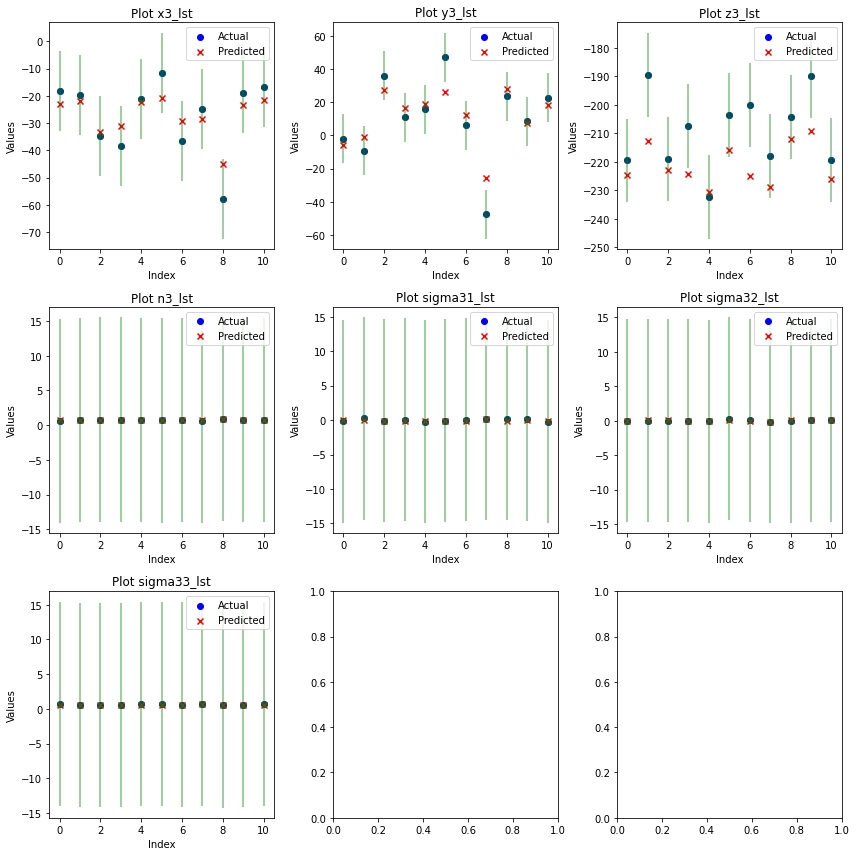

In [20]:
actual_names = ['x3_lst', 'y3_lst', 'z3_lst', 'n3_lst', 'sigma31_lst', 'sigma32_lst', 'sigma33_lst']
predictions_names = ['x3_lst_p', 'y3_lst_p', 'z3_lst_p', 'n3_lst_p', 'sigma31_lst_p', 'sigma32_lst_p', 'sigma33_lst_p']

actual_data = [x3_lst, y3_lst, z3_lst, n3_lst, sigma31_lst, sigma32_lst, sigma33_lst]
predictions_data = [x3_lst_p, y3_lst_p, z3_lst_p, n3_lst_p, sigma31_lst_p, sigma32_lst_p, sigma33_lst_p]

num_rows = 3
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

axs = axs.flatten()

# Tolerance value
tolerance = 14.71  


# Loop through the plots and plot actual vs. predicted for each
for i in range(min(num_rows * num_cols, len(actual_data))):
    # Generate x-axis values (index values)
    index_values = np.arange(len(actual_data[i]))

    # Plotting the scatter plot for actual values
    axs[i].scatter(index_values, actual_data[i], color='blue', label='Actual', marker='o')

    # Plotting the scatter plot for predicted values
    axs[i].scatter(index_values, predictions_data[i], color='red', label='Predicted', marker='x')

    # Plotting points with tolerance above and below actual values
    axs[i].errorbar(index_values, actual_data[i], yerr=tolerance, fmt='o', color='green', alpha=0.5)

    #set y-axis limits
    #axs[i].set_ylim([overall_min, overall_max])
    
    # Adding labels and title
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Values')
    axs[i].set_title(f'Plot {actual_names[i]}')

    # Adding a legend
    axs[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()